<a href="https://colab.research.google.com/github/amanjaiswal777/ICCIT-Workshop/blob/main/03_spam_detection_naive_bayes_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📧 Spam Detection — Naive Bayes (Complete Teaching Notebook)

This notebook builds a Naive Bayes spam detector from scratch using a **synthetic email dataset**.  
It covers:

- Synthetic dataset generation (spam vs ham)
- Text cleaning and preprocessing
- Feature extraction (Count / TF-IDF)
- Training Multinomial / Complement Naive Bayes
- Visualizing word probabilities and word clouds
- Confusion matrix and metrics analysis
- Hands-on assignments and commented solutions

> Notebook is Colab-ready and self-contained (no external downloads required).

In [1]:
# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud

sns.set_style('whitegrid')
np.random.seed(42)


## 1) Synthetic Email Dataset
We construct a small but varied synthetic corpus containing spam and ham templates with simple placeholders to increase variety.

In [2]:
# Build templates and expand into a dataset
spam_templates = [
    "Congratulations! You have won a $PRIZE$. Claim now: $LINK$",
    "URGENT: Your account is suspended. Verify at $LINK$",
    "Limited offer!!! Buy $PRODUCT$ at 90% OFF. $LINK$",
    "You have been selected for a cash reward of $AMOUNT$. $LINK$",
    "Earn $AMOUNT$ working from home. Apply now!",
    "Get your free $PRIZE$ today. Click $LINK$"
]

ham_templates = [
    "Hi team, the meeting is at $TIME$ tomorrow. Please confirm.",
    "Could you review the report draft by $TIME$?",
    "Lunch at $TIME$? Also, attach the slides for review.",
    "Reminder: Submit the expense form by $TIME$.",
    "Can we reschedule the call to $TIME$? Thanks.",
    "Thanks for the update — I will take a look and reply."
]

products = ['headphones', 'software', 'e-book', 'membership', 'watch', 'subscription']
prizes = ['iPhone', 'MacBook', 'gift card', 'vacation package']
amounts = ['1000 USD', '500 USD', '250 USD']
times = ['10am', '2pm', '4pm', 'Monday', 'Friday']

import random
random.seed(42)

def fill_template(t, spam=True):
    t = t.replace('$PRODUCT$', random.choice(products))
    t = t.replace('$PRIZE$', random.choice(prizes))
    t = t.replace('$AMOUNT$', random.choice(amounts))
    t = t.replace('$TIME$', random.choice(times))
    if spam:
        t = t.replace('$LINK$', f'http://{random.choice(["bit.ly","tinyurl.com","promo.example"])}/{random.randint(1000,9999)}')
    else:
        t = t.replace('$LINK$', '')
    return t

n_spam, n_ham = 1400, 1400
spam_msgs = [fill_template(random.choice(spam_templates), True) for _ in range(n_spam)]
ham_msgs = [fill_template(random.choice(ham_templates), False) for _ in range(n_ham)]

df = pd.DataFrame({'text': spam_msgs + ham_msgs, 'label': ['spam']*n_spam + ['ham']*n_ham})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
print('Dataset size:', df.shape)
df.head()

Dataset size: (2800, 2)


,text,label
0,Earn 500 USD working from home. Apply now!,spam
1,Congratulations! You have won a vacation packa...,spam
2,Could you review the report draft by Monday?,ham
3,Get your free iPhone today. Click http://promo...,spam
4,Could you review the report draft by 4pm?,ham


## 2) Quick EDA

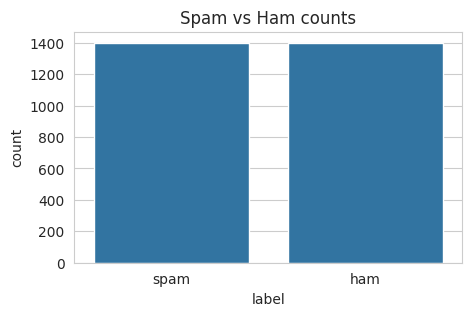

,text,label
1687,Limited offer!!! Buy subscription at 90% OFF. ...,spam
1070,Congratulations! You have won a vacation packa...,spam
549,"Hi team, the meeting is at Monday tomorrow. Pl...",ham
1193,URGENT: Your account is suspended. Verify at h...,spam
2303,Get your free MacBook today. Click http://prom...,spam
1977,Earn 250 USD working from home. Apply now!,spam


In [3]:
# Label balance
plt.figure(figsize=(5,3))
sns.countplot(x='label', data=df)
plt.title('Spam vs Ham counts')
plt.show()

# Example messages
df.sample(6, random_state=1)

## 3) Text Cleaning / Preprocessing
We'll lowercase text, remove punctuation, and normalize whitespace. This is intentionally simple so students can extend it (stemming, lemmatization, obfuscation handling).

In [4]:
def clean_text(s):
    s = s.lower()
    s = re.sub(r'http\S+', ' <LINK> ', s)  # replace links
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['clean'] = df['text'].apply(clean_text)
df.head()

,text,label,clean
0,Earn 500 USD working from home. Apply now!,spam,earn 500 usd working from home apply now
1,Congratulations! You have won a vacation packa...,spam,congratulations you have won a vacation packag...
2,Could you review the report draft by Monday?,ham,could you review the report draft by monday
3,Get your free iPhone today. Click http://promo...,spam,get your free iphone today click LINK
4,Could you review the report draft by 4pm?,ham,could you review the report draft by 4pm


## 4) Word Clouds & Top Indicative Words

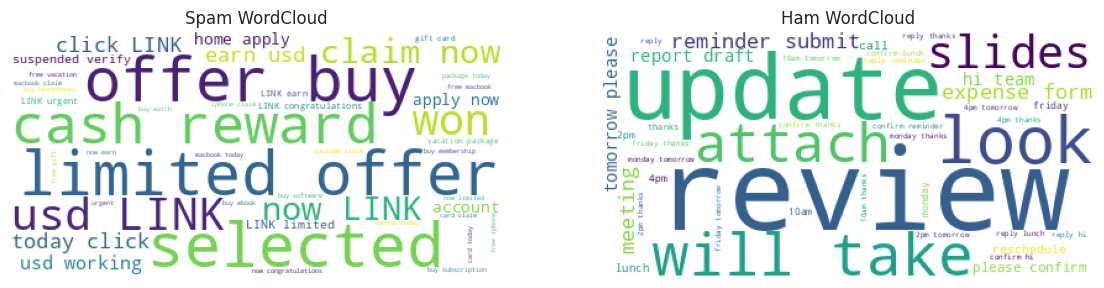

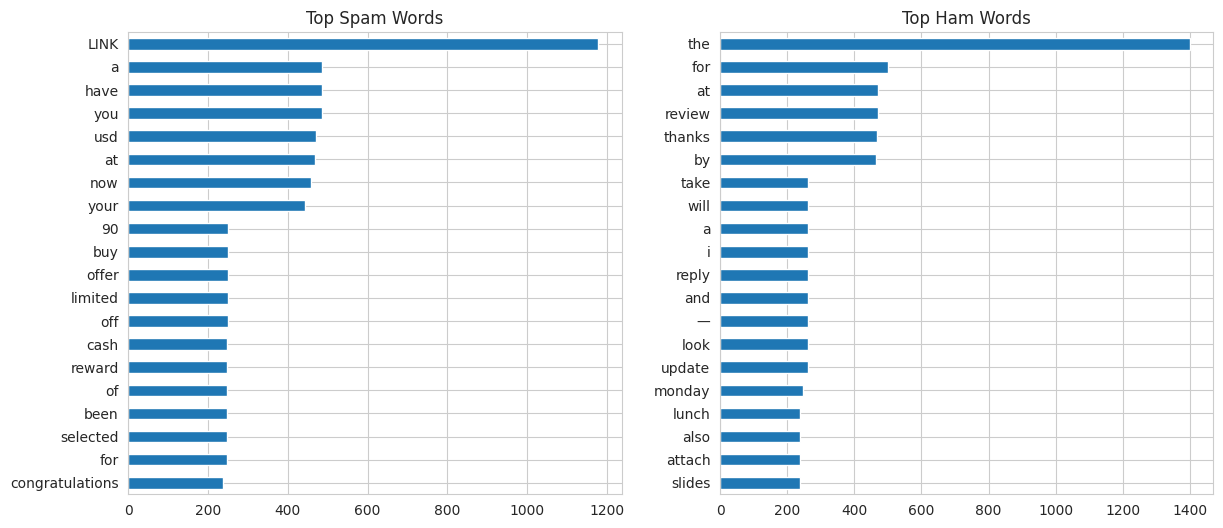

In [5]:
# Word clouds for spam and ham
spam_text = " ".join(df[df.label=='spam']['clean'])
ham_text = " ".join(df[df.label=='ham']['clean'])

fig, axes = plt.subplots(1,2, figsize=(14,6))
wc_spam = WordCloud(max_words=100, background_color='white').generate(spam_text)
wc_ham = WordCloud(max_words=100, background_color='white').generate(ham_text)

axes[0].imshow(wc_spam); axes[0].axis('off'); axes[0].set_title('Spam WordCloud')
axes[1].imshow(wc_ham); axes[1].axis('off'); axes[1].set_title('Ham WordCloud')
plt.show()

# Top words by frequency
def top_n_words(corpus, n=20):
    c = Counter(corpus.split())
    return pd.Series(dict(c.most_common(n)))

top_spam = top_n_words(spam_text, 20)
top_ham = top_n_words(ham_text, 20)

fig, ax = plt.subplots(1,2, figsize=(14,6))
top_spam.sort_values().plot(kind='barh', ax=ax[0]); ax[0].set_title('Top Spam Words')
top_ham.sort_values().plot(kind='barh', ax=ax[1]); ax[1].set_title('Top Ham Words')
plt.show()

## 5) Feature Extraction — TF-IDF & Count Vectorizer

In [6]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=3)
X_tfidf = tfidf.fit_transform(df['clean'])
y = (df['label']=='spam').astype(int)

# Count Vectorizer (for comparison later in assignment)
countvec = CountVectorizer(stop_words='english', min_df=3)
X_count = countvec.fit_transform(df['clean'])

print('TF-IDF shape:', X_tfidf.shape)
print('CountVec shape:', X_count.shape)

TF-IDF shape: (2800, 63)
CountVec shape: (2800, 63)


## 6) Train/Test Split and Model Training

In [7]:
# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X_tfidf, y, test_size=0.25, random_state=42, stratify=y)

# Train MultinomialNB and ComplementNB
mnb = MultinomialNB()
cnb = ComplementNB()

mnb.fit(X_tr, y_tr)
cnb.fit(X_tr, y_tr)

print('Models trained on TF-IDF features')

Models trained on TF-IDF features


## 7) Evaluation & Confusion Matrix

--- MultinomialNB ---
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       350
        spam       1.00      1.00      1.00       350

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

--- ComplementNB ---
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       350
        spam       1.00      1.00      1.00       350

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



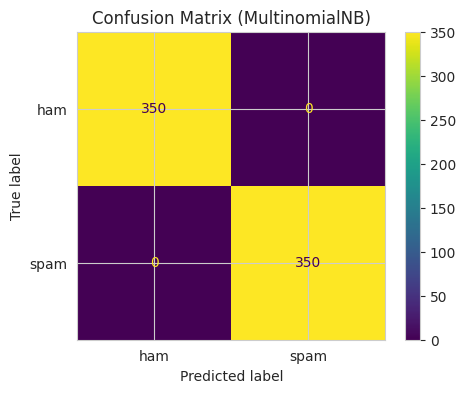

In [8]:
# Predictions
y_pred_mnb = mnb.predict(X_te)
y_pred_cnb = cnb.predict(X_te)

print('--- MultinomialNB ---')
print(classification_report(y_te, y_pred_mnb, target_names=['ham','spam']))

print('--- ComplementNB ---')
print(classification_report(y_te, y_pred_cnb, target_names=['ham','spam']))

# Confusion matrix for MultinomialNB
cm = confusion_matrix(y_te, y_pred_mnb)
disp = ConfusionMatrixDisplay(cm, display_labels=['ham','spam'])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax)
plt.title('Confusion Matrix (MultinomialNB)')
plt.show()

## 8) Word Probability Visualization (Log-Probability Ratios)

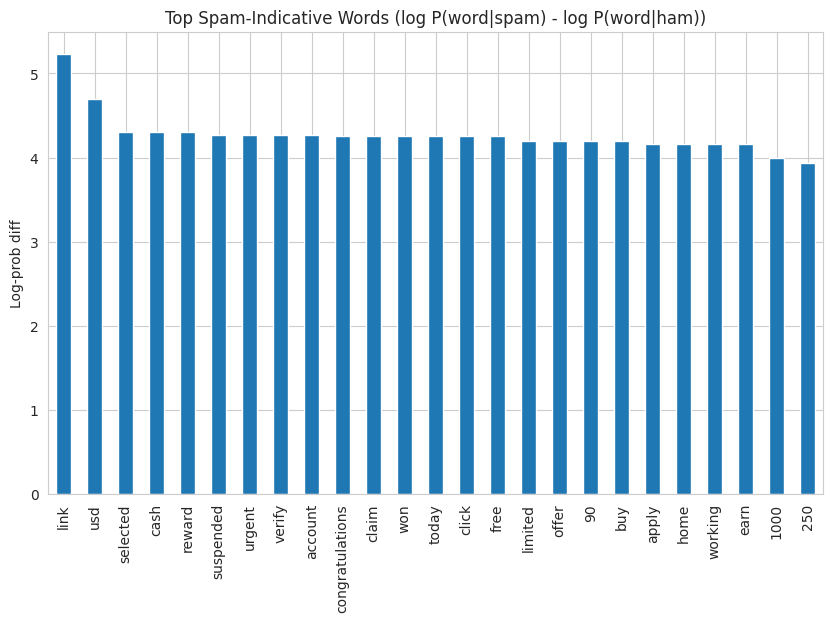

In [9]:
# Get feature names
feature_names = tfidf.get_feature_names_out()

# Use ComplementNB's feature_log_prob_ (shape: [n_classes, n_features])
log_probs = cnb.feature_log_prob_
# spam class is index 1 (since y: 0=ham,1=spam)
spam_strength = log_probs[1] - log_probs[0]
top_idx = np.argsort(spam_strength)[-25:][::-1]
top_words = pd.Series(spam_strength[top_idx], index=feature_names[top_idx])

plt.figure(figsize=(10,6))
top_words.plot(kind='bar')
plt.title('Top Spam-Indicative Words (log P(word|spam) - log P(word|ham))')
plt.ylabel('Log-prob diff')
plt.show()

## 9) Real-world Style Predictions

In [10]:
# Some realistic examples to classify
samples = [
    "Free vacation! Click http://promo.example/1234 to claim your prize",
    "Please find attached the monthly report and let me know your thoughts",
    "Limited time: get 90% off on our subscription. Visit http://bit.ly/9999",
    "Can you review the slides before the 2pm meeting?"
]

clean_samples = [clean_text(s) for s in samples]
X_s = tfidf.transform(clean_samples)
preds = cnb.predict(X_s)
for s, p in zip(samples, preds):
    print(f"{p} => {s}")

1 => Free vacation! Click http://promo.example/1234 to claim your prize
0 => Please find attached the monthly report and let me know your thoughts
1 => Limited time: get 90% off on our subscription. Visit http://bit.ly/9999
0 => Can you review the slides before the 2pm meeting?


## 10) Assignment
Try the following experiments:

1. Replace TF-IDF with CountVectorizer and retrain MultinomialNB and ComplementNB. Which vectorizer performs better on this dataset?

2. Add simple obfuscation handling: map common obfuscations like `v1agra` -> `viagra`, `c@sh` -> `cash`, and measure the impact on recall for spam.

3. Compare performance when using raw counts (CountVectorizer) + smoothing alpha values (e.g., alpha=0.1, 0.5, 1.0) for MultinomialNB.

Write code below to run experiments.

In [11]:
# --- Example starter for Assignment 1: CountVectorizer experiment
# Uncomment and run to test
# X_tr_c, X_te_c, y_tr_c, y_te_c = train_test_split(X_count, y, test_size=0.25, random_state=42, stratify=y)
# mnb_c = MultinomialNB(alpha=1.0).fit(X_tr_c, y_tr_c)
# y_pred_mnb_c = mnb_c.predict(X_te_c)
# print(classification_report(y_te_c, y_pred_mnb_c, target_names=['ham','spam']))

## ✅ Assignment Solutions (Reference) — Hidden
Below are suggested solution snippets. Uncomment to run.

In [12]:
# Solution examples:
# 1) CountVectorizer comparison
# X_tr_c, X_te_c, y_tr_c, y_te_c = train_test_split(X_count, y, test_size=0.25, random_state=42, stratify=y)
# mnb_c = MultinomialNB().fit(X_tr_c, y_tr_c)
# cnb_c = ComplementNB().fit(X_tr_c, y_tr_c)
# print('MultinomialNB on CountVec:\n', classification_report(y_te_c, mnb_c.predict(X_te_c), target_names=['ham','spam']))
# print('ComplementNB on CountVec:\n', classification_report(y_te_c, cnb_c.predict(X_te_c), target_names=['ham','spam']))

# 2) Obfuscation handling (simple mapping)
# mapping = {'v1agra':'viagra', 'c@sh':'cash', 'fr33':'free'}
# def deobfuscate(s):
#     for k,v in mapping.items():
#         s = s.replace(k, v)
#     return s
# df['clean2'] = df['clean'].apply(deobfuscate)
# tfidf2 = TfidfVectorizer(stop_words='english', min_df=3)
# X_tfidf2 = tfidf2.fit_transform(df['clean2'])
# X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X_tfidf2, y, test_size=0.25, random_state=42, stratify=y)
# cnb2 = ComplementNB().fit(X_tr2, y_tr2)
# print(classification_report(y_te2, cnb2.predict(X_te2), target_names=['ham','spam']))

# 3) Smoothing alpha sweep
# for a in [0.1, 0.5, 1.0]:
#     m = MultinomialNB(alpha=a).fit(X_tr, y_tr)
#     print('alpha=', a)
#     print(classification_report(y_te, m.predict(X_te), target_names=['ham','spam']))
